In [51]:
####################### COMPTE-RENDU: INFMDI341 TP-KERNEL-METHODS ###########################

#  Student: Shuyu Dong  22/06/2015

###################################   TP SOURCE   ###########################################

# Authors: Bellet, Gramfort, Salmon
from math import sqrt
import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd
from sklearn.metrics.pairwise import rbf_kernel

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u,s,v=svds(gram_mat,k)
        # TODO Question 2-3
    else:
        U,S,V=svd(gram_mat) #full by default--> both U,V: [nxn] here (for G=<Gram_matrix>)
        s=S[:k]
        u=U[:k,:k]
        v=V[:k,:k]
    gram_mat_k = (u.dot(np.diag(s))).dot(v)
    return gram_mat_k, u, s


def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    # TODO Question 4
    [n1,p]=X_train.shape
    n2=X_test.shape[0]
    # p iid Gaussian vectors 
    W=sqrt(2.0*gamma)*rng.randn(p,c)
    # uniformly distributed phases in [0,2\pi)
    b=rng.uniform(0,2*np.pi,size=c)
    # x*W ([n1 x c]) + b([,c] constant along dim-0)
    X_new_train = sqrt(2.0/c)*np.cos(X_train.dot(W)+np.outer(np.ones(n1),b))
    X_new_test = sqrt(2.0/c)*np.cos(X_test.dot(W)+np.outer(np.ones(n2),b))
    
    return X_new_train, X_new_test


def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    # TODO Question 6
    [n1,p] = X_train.shape

    I=rng.randint(n1,size=c)
    G=rbf_kernel(X_train[I],X_train[I],gamma=gamma)
    Gk,uk,sk=rank_trunc(G,k) #fast: by default True
    Mk= uk.dot(np.diag(np.sqrt(1./sk)))

    Ttr = rbf_kernel(X_train, X_train[I],gamma=gamma)
    Tte = rbf_kernel(X_test,X_train[I],gamma=gamma)
    X_new_train =  Ttr.dot(Mk)
    X_new_test = Tte.dot(Mk)

    return X_new_train, X_new_test

In [54]:

##################################  TP SCRIPT  #########################################
########################################################################################
from time import time
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets.mldata import fetch_mldata

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

####################################################################
# Download the data (if not present); load it as numpy arrays
dataset_name = 'covtype.binary'
covtype = fetch_mldata(dataset_name)
covtype.data = covtype.data.toarray()  # convert to dense

####################################################################
# Extract features
X_train, X_test, y_train, y_test = \
    train_test_split(covtype.data[:50000, :], covtype.target[:50000],
                     train_size=10000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
######################################################################
#######################    TP SCRIPT   ###############################
# SVM classfication (Question 1)

from sklearn.svm import SVC, LinearSVC

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_kernel0=clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel0 = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel0)
# print'timing_kernel: ',str(timing_kernel)

# TODO with LinearSVC
print("Fitting SVC linear on %d samples..." % X_train.shape[0])
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()
# TODO
accuracy_linear0=clf.score(X_test,y_test)
print("done in %0.3fs" % (time() - t1))
timing_linear0 = time() - t0
print("classification accuracy: %0.3f" % accuracy_linear0)
# print'timing_linear: ',str(timing_linear)


Fitting SVC rbf on 10000 samples...
done in 3.792s
Predicting with SVC rbf on 40000 samples...
done in 9.197s
classification accuracy: 0.875
Fitting SVC linear on 10000 samples...
done in 0.188s
Predicting with SVC linear on 40000 samples...
done in 0.005s
classification accuracy: 0.863


$\textbf{Questions 1}$

First we see that a RBF-kernel SVM requires a training time of around $20$ times longer than that of a linear SVM on the same data. The difference in computation time for prediction is even $much\ \ greater$: the RBF-SVM is slower by a factor of $O(10^3)$. 

Though the classification accuracy of the RBF-kernel is slightly higher than that of the linear SVM on test data. These two comparisons reflect a two-fold nature of the kernel SVM in general: 
    
   (1) - Kernel SVM induces non-linear properties underlying the data features that may favor the discrimination of different classes and thus give rise to classification results;
   
   (2) - because of this nature, the computation of $x_i^{\top}x_j$ that appear in the dual form of SVM become $k(x_i,x_j),$ in our case, $\exp(-\gamma\Vert x_i-x_j\Vert_2^2),$ thus requires much more computation time. This difference results in the slowing down of RBF-SVM from the linear one (although the dual form solution is not activated for linear-SVM, it doesn't change too much the comparison), the time complexity for training switch from $O(nd)$ ($d$ for feature space inner product and $n$ for number of samples) to $O(n^2);$ and for prediction, we have to compute $k(x_i^*,x_t)$ for a number of support vectors $x_i^*$ (bounded by $n$), the time complexity often switch from $O(d)$(linear case: $w^{\top}x_t$) to $O(n)$ or larger, which is the case for our slowing down here by a factor  $>O(10000/54).$ 

done q23


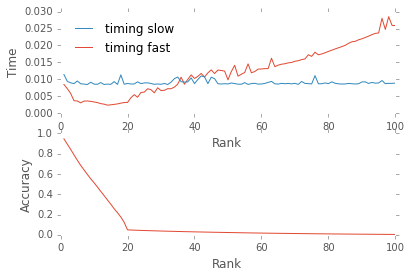

In [55]:
%matplotlib inline
####################################################################
# Gram approximation
# from TP_kernel_approx_source import rank_trunc, nystrom, random_features

p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
accuracy = np.zeros(n_ranks)

# TODO : Question 2 Implement rank_trunc function in source file.
# TODO : Question 3 Evaluate accuracy with Frobenius norm as a function
# of the rank for both svd solvers

# Use linalg.norm(A, 'fro') to compute Frobenius norm of A
for k, rank in enumerate(ranks):
    tf=time()
    gk,_,_=rank_trunc(gram_signal,rank)
    timing_fast[k]=time()-tf
    tsl=time()
    gks,_,_=rank_trunc(gram_signal,rank,fast=False)
    timing_slow[k]=time()-tsl
    accuracy[k]= linalg.norm(gram_signal-gk,ord='fro')/linalg.norm(gram_signal,ord='fro')
#    accuracy[k]= linalg.norm(gram_signal-gks,ord='fro')/linalg.norm(gram_signal,ord='fro')

print("done q23")
####################################################################
# Display
opt={'figroot':'figs/'}

fig, axes = plt.subplots(ncols=1, nrows=2)
ax1, ax2 = axes.ravel()

linef, =ax1.plot(ranks, timing_fast, '-')
lines, =ax1.plot(ranks, timing_slow, '-')
ax1.legend({linef,lines},{'timing fast','timing slow'},loc=2)

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, accuracy, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Accuracy')
# plt.tight_layout()
plt.show()

$\textbf{Questions 2-3}$

In the implementation $\texttt{rank_trunc}$, two options are given:

   (1) Fast option uses the imported function $\texttt{svds}$ that only calculates the first $k$ largest singular values and the corresponding orthogonal matrices $U_k, U_k^{\top}$ (particularily for real symmetric matrices including Gram, the SVD is equivalent to the eigenvalue decomposition $U\Sigma U^{\top}$). 
    
   (2) Slow option calculates by default the full matrices for the SVD of G, this is done by the imported $\texttt{svd}$. We just need to truncate out the first $k\times k$ blocs to compute our approximation $$\tilde{G}_k=U_k\Sigma_k U_k^{\top},$$ where $U_k=\texttt{U[:k,:k]}$ and $\Sigma_k=\texttt{np.diag(S[:k]))}$.  
   
   The curve for the two options' computation time correspond well to their respective computational strategies: the time complexity for $fast$ naturally grows almost linearly w.r.t rank and for $slow$ remains constant modulo some critical/interesting points (independent of the option) that makes the computation fluctuate. After a certain value of $rank$, the $slow$ mode will be faster than the $fast$ mode.
   
   However, since the SNR is very large, the real rank of the noise-signal mixed Gram matrix is most likely to be $\texttt{r_signal}=20$, the $rank$ can be well set at $\sim 20$ (without lossing the slightest accuracy), for which the $fast$ mode is faster.
   

In [56]:
####################################################################
# Random Kernel Features:

n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features

# TODO : Question 4 Implement random features in source file.

Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

# TODO : Question 5 Estimate training, testing time and accuracy
print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
# TODO
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("Q5: Linear-SVM training done in %0.3fs" % (time() - t0))

print("Predicting with linear-SVM on %d samples..." % n_samples_test)
t1 = time()
# TODO
accuracy_kernel=clf.score(Z_test,y_test)
print("prediction done in %0.3fs" % (time() - t1))
timing_q5 = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)
# print'Q5: training-testing time: ',str(timing_q5)


Fitting SVC linear on 10000 samples...
Q5: Linear-SVM training done in 1.013s
Predicting with linear-SVM on 40000 samples...
prediction done in 0.018s
classification accuracy: 0.875


$\textbf{Questions 4-5}$

  We can see that when trained/predicted on the RKF of the data, the computation times for training and prediction, though larger than those with raw data in Question 1, are very close to the previous ones; while the classification accuracy has increased and becomes comparable to that of the RBF-SVM.
  
  Since we compute the approximation (with cheap RKF) of images in the Gaussian kernel's feature space of dimension $c=300>d=54$, we are freed from having to use heavy RBF-SVM in return. As a result, we have the above overall improvement. 

In [57]:
####################################################################
# SVM Nystrom:

# TODO : Question 6-7 Implement nystrom in source file.

Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=200, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t1 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 10000 samples...
done in 0.678s
Predicting with SVC linear on 40000 samples...
done in 0.014s
classification accuracy: 0.879


$\textbf{Questions 6-7}$

Now we apply the linear SVM on 200-dimensional features by Nyström's approximation. Similairily the tranining and prediction times have risen slightly but remain in the same order compared to those in Question 1 with linear SVM on raw data, the classification accuracy has risen by $1.3\%$ which is now even slightly better than that of the RBF-kernel SVM.

In [58]:
####################################################################
# Results / comparisons:

ranks = list(range(20, 500, 50))
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

for i, c in enumerate(ranks):
    print('task %d'%(i)+'--- c=%d'%c)
    t0 = time()
    # TODO Question 7/// 8 en fait
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test,y_test)
    timing_rkf[i] = time() - t0
#     print 'shape of Ztrain: ', str(Z_train.shape)
    t1=time()
    Z_trainn, Z_testn = nystrom(X_train, X_test, gamma, c=c,k=c-10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_trainn, y_train)
    accuracy_nystrom[i] = clf.score(Z_testn,y_test)
    timing_nystrom[i] = time() - t1
#     print 'shape of Ztrain_nystrom: ',str(Z_trainn.shape)


task 0--- c=20
task 1--- c=70
task 2--- c=120
task 3--- c=170
task 4--- c=220
task 5--- c=270
task 6--- c=320
task 7--- c=370
task 8--- c=420
task 9--- c=470


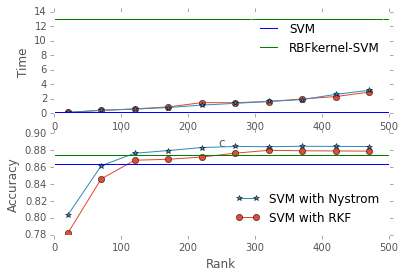

In [62]:
##################### Suite: question 8 #######################
fig, axes = plt.subplots(ncols=1, nrows=2)
ax1, ax2 = axes.ravel()

ltr, = ax1.plot(ranks, timing_rkf, 'o-')
ltn = ax1.plot(ranks, timing_nystrom, '*-')
ax1.axhline(y=timing_linear0,label='SVM')
ax1.axhline(y=timing_kernel0,color='g',label='RBFkernel-SVM')

ax1.set_xlabel('c')
ax1.set_ylabel('Time')
ax1.legend(loc=1)
lar, = ax2.plot(ranks, accuracy_rkf, 'o-')
lan, = ax2.plot(ranks,accuracy_nystrom,'*-')
lalin = ax2.axhline(y=accuracy_linear0)
lakern = ax2.axhline(y=accuracy_kernel0,color='g')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Accuracy')
ax2.legend({lar,lan},{'SVM with RKF','SVM with Nystrom'},loc=4)
# plt.tight_layout()
plt.show()

$\textbf{Question 8}$

  (1) - We see from the first graph that in terms of time performance for training+prediction, linear SVM with Random Kernel Features and Nystrom approximations are very close and both slow down within a reasonable rate as $rank$ increases, their computation times increase by a factor $<O(10)$ compared to linear SVM in question 1 and are always much shorter compared to the RBFkernel-SVM.
  
  (2) - In terms of classification performance, we see that starting from $rank=120,$ the classification accuracies of both RKF and Nystrom based SVMs become better than the linear SVM in question 1 and close to the RBFkernel-SVM; with $rank$ ranging from $320\sim 500,$ their performances become better than the RBFkernel-SVM and these are done, as we have seen, within much shorter computation times.
  
  In conclusion, RBF and Nystrom approximations provide good solutions for the need to do supervised classification with non-linear kernel features with reduced computation time compared to classical kernel SVM, for example, allowing applications in large-scale data.
